# Japan Airlines Cargo Traffic Segmentation

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### KMeansClustering Class for Japan Airlines Cargo Traffic

In [2]:
class KMeansClustering:
    def __init__(self, num_clusters, max_iters=100, tol=1e-4, random_state=42):
        self.n_clusters = num_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        
        torch.manual_seed(random_state)
        
    def initialize_centroids(self, X):
        n_samples = X.shape[0]
        if n_samples < self.n_clusters:
            raise ValueError("Number of samples must be greater than number of clusters")
            
        indices = torch.randperm(n_samples)[:self.n_clusters]
        self.centroids = X[indices].clone()
        
    def compute_distances(self, X):
        distances = torch.zeros(X.shape[0], self.n_clusters, device=X.device)
        for i, centroid in enumerate(self.centroids):
            distances[:, i] = torch.sum((X - centroid) ** 2, dim=1)
        return distances
        
    def assign_clusters(self, X):
        distances = self.compute_distances(X)
        return torch.argmin(distances, dim=1)
        
    def update_centroids(self, X, labels):
        new_centroids = []
        for i in range(self.n_clusters):
            cluster_mask = (labels == i)
            cluster_points = X[cluster_mask]
            if cluster_points.shape[0] > 0:
                new_centroids.append(cluster_points.mean(dim=0))
            else:
                new_centroids.append(self.centroids[i].clone())
        self.centroids = torch.stack(new_centroids)
        
    def fit(self, X):
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)
            
        self.initialize_centroids(X)
        
        for _ in range(self.max_iters):
            labels = self.assign_clusters(X)
            prev_centroids = self.centroids.clone()
            self.update_centroids(X, labels)
            
            if torch.allclose(prev_centroids, self.centroids, atol=self.tol):
                break
                
        return labels
        
    def predict(self, X):
        if self.centroids is None:
            raise ValueError("Model must be fitted before making predictions")
            
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)
            
        return self.assign_clusters(X)
        
    def inertia_(self, X, labels):
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)
            
        inertia = 0.0
        for i in range(self.n_clusters):
            cluster_mask = (labels == i)
            cluster_points = X[cluster_mask]
            if cluster_points.shape[0] > 0:
                inertia += torch.sum((cluster_points - self.centroids[i]) ** 2)
        return inertia.item()

### Load the Data

In [3]:
df = pd.read_csv("japan_airlines_cargo_traffic.csv")

In [4]:
df.head()

,Cargo_ID,Date,Origin,Destination,Cargo_Type,Weight_kg,Volume_m3,Priority,Status,Revenue_USD
0,JAL001,2024-08-28,Sapporo,Singapore,Pharmaceuticals,3093.37,36.59,High,In Transit,4592.54
1,JAL002,2024-07-04,Osaka,Singapore,Textiles,4240.10,12.83,High,In Transit,6410.83
2,JAL003,2024-09-13,Osaka,Shanghai,Perishable,961.40,13.95,Low,Delayed,7241.86
3,JAL004,2024-06-17,Tokyo,Sydney,Pharmaceuticals,4848.90,1.24,High,Delayed,5437.93
4,JAL005,2024-09-27,Nagoya,Sydney,Textiles,862.20,38.62,Low,Delivered,697.67


### Extract relevant features

In [5]:
X = df[["Weight_kg", "Volume_m3"]].values

### Normalize the data

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Initialize the KMeansClustering class

In [7]:
kmeans = KMeansClustering(num_clusters=3, random_state=42)

In [8]:
labels = kmeans.fit(X_scaled)
df["Cluster"] = labels

In [9]:
cluster_stats = df.groupby("Cluster")[["Weight_kg", "Volume_m3"]].mean()
print("Cluster Statistics:")
print(cluster_stats)

Cluster Statistics:
           Weight_kg  Volume_m3
Cluster                        
0        1037.310164  16.603115
1        3904.729167  13.402167
2        2543.458987  38.849747


### Visualize the clusters

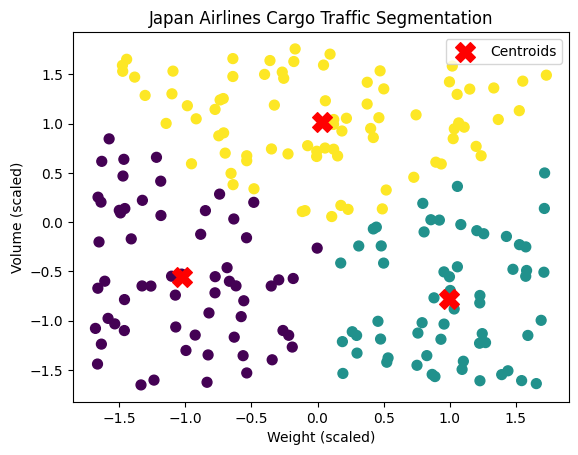

In [10]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap="viridis", s=50)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c="red", marker="X", s=200, label="Centroids")
plt.title("Japan Airlines Cargo Traffic Segmentation")
plt.xlabel("Weight (scaled)")
plt.ylabel("Volume (scaled)")
plt.legend()
plt.show()